<a href="https://colab.research.google.com/github/PIYAL-DATTA/Multi_Cancer/blob/main/Multi_Cancer_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Colab cell 1: common installs
!pip install kaggle
!pip install tensorflow


In [14]:
# import kagglehub

# # Download latest version from Kaggle
# path = kagglehub.dataset_download("obulisainaren/multi-cancer")

# print("Dataset downloaded to:", path)


In [15]:
import os
import glob

# Cell 2: Set up dataset path with correct structure
dataset_path = r"C:\Users\Piyal\.cache\kagglehub\datasets\obulisainaren\multi-cancer\versions\3\Multi Cancer\Multi Cancer" # path + "/Multi Cancer/Multi Cancer"

print("Checking dataset at:", dataset_path)

# Check what's in the dataset directory
if os.path.exists(dataset_path):
    cancer_types = os.listdir(dataset_path)
    print("Found cancer types:", cancer_types)

    # Define folders to exclude
    exclude_folders = [
        'all_benign', 'breast_benign', 'kidney_normal',
        'colon_bnt', 'lung_bnt', 'oral_normal'
    ]

    # Count images recursively in each cancer type
    total_images = 0
    for cancer_type in cancer_types:
        cancer_path = os.path.join(dataset_path, cancer_type)
        if os.path.isdir(cancer_path):
            # Look for subdirectories within each cancer type
            subfolders = [f for f in os.listdir(cancer_path) if os.path.isdir(os.path.join(cancer_path, f))]

            # Filter out excluded folders
            filtered_subfolders = [folder for folder in subfolders if folder not in exclude_folders]

            cancer_type_images = 0
            for subfolder in filtered_subfolders:
                subfolder_path = os.path.join(cancer_path, subfolder)
                # Count images in this subfolder
                images = (glob.glob(os.path.join(subfolder_path, "*.jpg")) +
                         glob.glob(os.path.join(subfolder_path, "*.jpeg")) +
                         glob.glob(os.path.join(subfolder_path, "*.png")))
                cancer_type_images += len(images)

            print(f"   {cancer_type}: {cancer_type_images} images (in {len(subfolders)} subfolders)")
            if subfolders:
                print(f"      Subfolders: {subfolders}")
            total_images += cancer_type_images

    print(f"   Total images: {total_images}")
    data_dir = dataset_path
else:
    print("❌ Dataset path does not exist")
    data_dir = None

Checking dataset at: C:\Users\Piyal\.cache\kagglehub\datasets\obulisainaren\multi-cancer\versions\3\Multi Cancer\Multi Cancer
Found cancer types: ['ALL', 'Brain Cancer', 'Breast Cancer', 'Cervical Cancer', 'Kidney Cancer', 'Lung and Colon Cancer', 'Lymphoma', 'Oral Cancer']
   ALL: 15000 images (in 4 subfolders)
      Subfolders: ['all_benign', 'all_early', 'all_pre', 'all_pro']
   Brain Cancer: 15000 images (in 3 subfolders)
      Subfolders: ['brain_glioma', 'brain_menin', 'brain_tumor']
   Breast Cancer: 5000 images (in 2 subfolders)
      Subfolders: ['breast_benign', 'breast_malignant']
   Cervical Cancer: 25000 images (in 5 subfolders)
      Subfolders: ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']
   Kidney Cancer: 5000 images (in 2 subfolders)
      Subfolders: ['kidney_normal', 'kidney_tumor']
   Lung and Colon Cancer: 15000 images (in 5 subfolders)
      Subfolders: ['colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc']
   Lymphoma: 15000 imag

In [16]:
# Cell 3: Data preparation with TensorFlow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

if data_dir:
    IMG_SIZE = (224, 224)
    BATCH = 32  # Good for your 6.85GB VRAM

    print(f"\nSetting up data generators from: {data_dir}")

    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True
    )

    train_gen = datagen.flow_from_directory(
        data_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH,
        subset='training',
        class_mode='categorical'
    )

    val_gen = datagen.flow_from_directory(
        data_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH,
        subset='validation',
        class_mode='categorical',
        shuffle=False  # Important for consistent validation
    )

    num_classes = len(train_gen.class_indices)
    class_names = list(train_gen.class_indices.keys())

    print(f"\n✅ Data loaded successfully!")
    print(f"Classes: {num_classes}")
    print(f"Class names: {class_names}")
    print(f"Training samples: {train_gen.samples}")
    print(f"Validation samples: {val_gen.samples}")
    print(f"Steps per epoch: {len(train_gen)}")
else:
    print("❌ Cannot set up data generators - data directory not found")
    train_gen, val_gen = None, None
    num_classes = 8
    class_names = []


Setting up data generators from: C:\Users\Piyal\.cache\kagglehub\datasets\obulisainaren\multi-cancer\versions\3\Multi Cancer\Multi Cancer
Found 104002 images belonging to 8 classes.
Found 26000 images belonging to 8 classes.

✅ Data loaded successfully!
Classes: 8
Class names: ['ALL', 'Brain Cancer', 'Breast Cancer', 'Cervical Cancer', 'Kidney Cancer', 'Lung and Colon Cancer', 'Lymphoma', 'Oral Cancer']
Training samples: 104002
Validation samples: 26000
Steps per epoch: 3251


In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# --- Configuration ---
# Your input image size (e.g., 224x224)
INPUT_SHAPE = (224, 224, 3)
# The number of classes (must match your dataset, which is 8)
NUM_CLASSES = 8
# Size of the patches (e.g., 16x16)
PATCH_SIZE = 16
# Number of patches per image (224/16)^2 = 196
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE) ** 2
# Size of the embedded patches
PROJECTION_DIM = 64
# Number of Transformer blocks
TRANSFORMER_LAYERS = 8
# Number of attention heads
NUM_HEADS = 4
# Size of the hidden layer in the MLP
MLP_HEAD_UNITS = [2048, 1024]
# Dropout rate
DROPOUT_RATE = 0.1

In [18]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        # Extract patches from the images
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        # Flatten the patches: (Batch_Size, Num_Patches, Patch_Area)
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [19]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        # Learnable Positional Embeddings
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        # Create positional indices (0, 1, 2, ..., NUM_PATCHES - 1)
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        # Project the patch into the embedding dimension
        encoded = self.projection(patch)
        # Add positional embedding
        return encoded + self.position_embedding(positions)

In [20]:
def create_vit_classifier():
    # 1. Inputs
    inputs = layers.Input(shape=INPUT_SHAPE)

    # 2. Extract and Encode Patches
    # (B, H, W, C) -> (B, N, P*P*C) -> (B, N, PROJECTION_DIM)
    patches = Patches(PATCH_SIZE)(inputs)
    encoded_patches = PatchEncoder(NUM_PATCHES, PROJECTION_DIM)(patches)

    # 3. Transformer Blocks (The core of ViT)
    for _ in range(TRANSFORMER_LAYERS):
        # Layer Normalization 1 (Pre-Attention)
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        # Multi-Head Self-Attention (MHSA)
        attention_output = layers.MultiHeadAttention(
            num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=DROPOUT_RATE
        )(x1, x1)

        # Skip connection 1 (Add Attention Output to Input)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization 2 (Pre-MLP)
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # Feed-Forward Network (MLP)
        x3 = layers.Dense(PROJECTION_DIM * 4, activation=tf.nn.gelu)(x3)
        x3 = layers.Dropout(DROPOUT_RATE)(x3)
        x3 = layers.Dense(PROJECTION_DIM)(x3)
        x3 = layers.Dropout(DROPOUT_RATE)(x3)

        # Skip connection 2 (Add MLP Output to Attention Output)
        encoded_patches = layers.Add()([x3, x2])

    # 4. Final Classification Head
    # Normalize the output of the last block
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    # Global average pooling across all patches
    representation = layers.GlobalAveragePooling1D()(representation)

    # MLP Head for classification
    for units in MLP_HEAD_UNITS:
        representation = layers.Dense(units, activation=tf.nn.gelu)(representation)
        representation = layers.Dropout(DROPOUT_RATE)(representation)

    # Final classification layer (8 units for 8 classes)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(representation)

    # 5. Build and Compile Model
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

# Initialize and summarize the ViT model
vit_model = create_vit_classifier()
vit_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ patches (Patches)             │ (None, None, 768)         │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ patch_encoder (PatchEncoder)  │ (None, 196, 64)           │          61,760 │ patches[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization           │ (None, 196, 64)           │             128 │ patch_encoder[0][0]        │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention          │ (None, 196, 64)           │          66,368 │ layer_normalization[0][0], │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 196, 64)           │               0 │ multi_head_attention[0][0… │
│                               │                           │                 │ patch_encoder[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_1         │ (None, 196, 64)           │             128 │ add[0][0]                  │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 196, 256)          │          16,640 │ layer_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 196, 256)          │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 196, 64)           │          16,448 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 196, 64)           │               0 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 196, 64)           │               0 │ dropout_2[0][0], add[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_2         │ (None, 196, 64)           │             128 │ add_1[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_1        │ (None, 196, 64)           │          66,368 │ layer_normalization_2[0][… │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 3,099,080 (11.82 MB)

 Trainable params: 3,099,080 (11.82 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 1. Initialize Callbacks
checkpoint_filepath = 'vit_best_weights.weights.h5'

# Saves the best model weights based on validation loss
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)

# Stops training if validation loss does not improve for 5 consecutive epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min',
    verbose=1,
    restore_best_weights=True # Restores weights from the best epoch
)

# 2. Run the Training
print("Starting ViT training...")
history = vit_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5 # Set a reasonably high number, relying on EarlyStopping
    # callbacks=[checkpoint, early_stop],
)

# 3. Load the best weights saved by the checkpoint
# vit_model.load_weights(checkpoint_filepath)
print("\nTraining finished. Loaded best model weights.")

Starting ViT training...
Epoch 1/5
3251/3251 ━━━━━━━━━━━━━━━━━━━━ 2128s 650ms/step - accuracy: 0.9512 - loss: 0.1391 - val_accuracy: 0.9756 - val_loss: 0.0745
Epoch 2/5
3251/3251 ━━━━━━━━━━━━━━━━━━━━ 2100s 646ms/step - accuracy: 0.9888 - loss: 0.0352 - val_accuracy: 0.9850 - val_loss: 0.0482
Epoch 3/5
3251/3251 ━━━━━━━━━━━━━━━━━━━━ 2134s 656ms/step - accuracy: 0.9923 - loss: 0.0251 - val_accuracy: 0.9927 - val_loss: 0.0220
Epoch 4/5
3251/3251 ━━━━━━━━━━━━━━━━━━━━ 2074s 638ms/step - accuracy: 0.9945 - loss: 0.0179 - val_accuracy: 0.9839 - val_loss: 0.0512
Epoch 5/5
3251/3251 ━━━━━━━━━━━━━━━━━━━━ 2179s 670ms/step - accuracy: 0.9951 - loss: 0.0161 - val_accuracy: 0.9780 - val_loss: 0.0613

Training finished. Loaded best model weights.


In [23]:
!pip install scikit-learn

  Using cached scikit_learn-1.7.2-cp313-cp313-win_amd64.whl.metadata (11 kB)
Using cached scikit_learn-1.7.2-cp313-cp313-win_amd64.whl (8.7 MB)


In [25]:
import numpy as np
from sklearn.metrics import classification_report

# 1. Reset the validation generator
# This ensures that the true labels (y_true) are extracted in the same order as predictions.
val_gen.reset()

# 2. Extract true labels (y_true)
# val_gen.classes contains the true labels. We use index_array to ensure the correct order.
y_true = val_gen.classes[val_gen.index_array][:val_gen.samples]


# 3. Get predictions (y_pred_proba)
print("Generating predictions on validation data...")
# Predict on the entire validation set
y_pred_proba = vit_model.predict(
    val_gen,
    steps=len(val_gen),
    verbose=1
)

# 4. Convert probabilities to class indices (y_pred)
# np.argmax gets the index (0 through 7) of the highest probability
y_pred = np.argmax(y_pred_proba, axis=1)

# 5. Get class names and labels
target_names = list(val_gen.class_indices.keys())
# Define the expected labels (0, 1, ..., 7) to avoid the previous ValueError
labels = list(range(len(target_names)))


# 6. Print the Classification Report
print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(
    y_true,
    y_pred,
    labels=labels,        # Explicitly define the expected labels (0, 1, ..., 7)
    target_names=target_names
))

Generating predictions on validation data...
813/813 ━━━━━━━━━━━━━━━━━━━━ 237s 290ms/step

--- CLASSIFICATION REPORT ---
                       precision    recall  f1-score   support

                  ALL       1.00      1.00      1.00      4000
         Brain Cancer       1.00      1.00      1.00      3000
        Breast Cancer       0.83      0.99      0.90      2000
      Cervical Cancer       1.00      0.95      0.97      5000
        Kidney Cancer       1.00      1.00      1.00      2000
Lung and Colon Cancer       1.00      0.95      0.97      5000
             Lymphoma       1.00      1.00      1.00      3000
          Oral Cancer       0.95      0.98      0.96      2000

             accuracy                           0.98     26000
            macro avg       0.97      0.98      0.98     26000
         weighted avg       0.98      0.98      0.98     26000



In [29]:
!pip install matplotlib
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


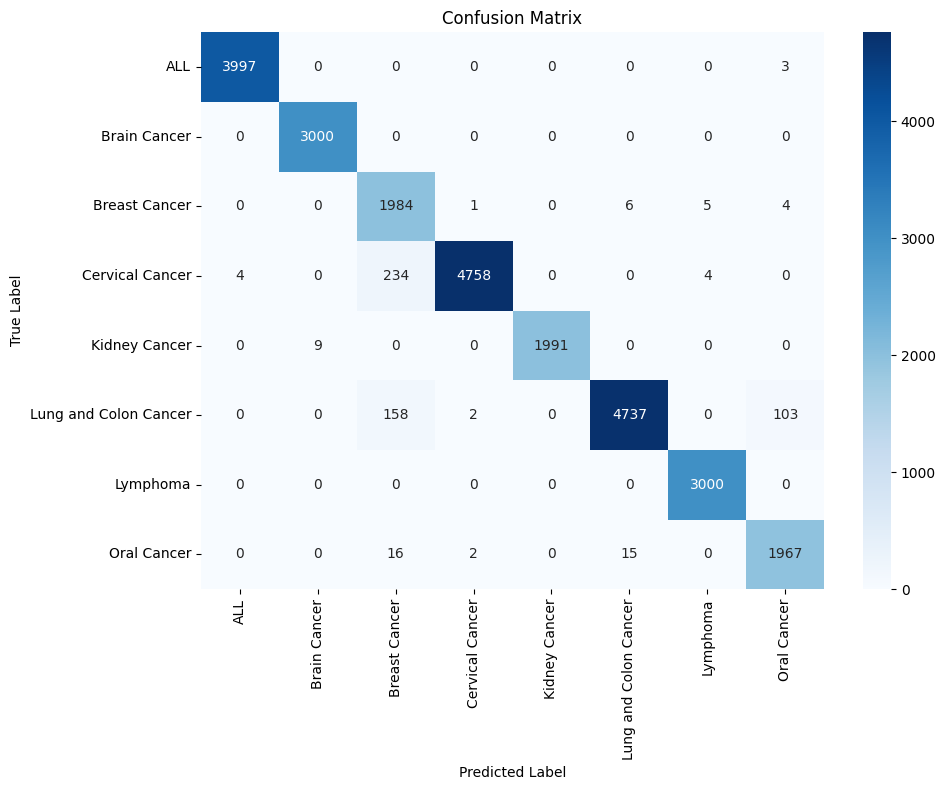

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 6. Calculate the Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 7. Plot the Confusion Matrix as a Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,              # Show the counts in the cells
    fmt='d',                 # Format as integer counts
    cmap='Blues',            # Color map style
    xticklabels=class_names, # Use class names for x-axis
    yticklabels=class_names  # Use class names for y-axis
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# If you need to save the plot:
# plt.savefig('confusion_matrix.png')